# Single Channel Analysis

In [26]:

import tarfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from commands.datastore import Datastore
from experiments.single_channel.experiment import SingleChannelExperiment
from functools import reduce
from parse import parse
import numpy as np

sns.set_theme(context="paper", style="whitegrid", rc={"text.usetex" : False})
sns.set_theme(context="paper", font="qhv", style="ticks", rc={
    "text.usetex" : True,
})

data_store = Datastore().derive("all_layers")
figures = data_store / "figures"
figures.mkdir(exist_ok=True, parents=True)

def get_parent_experiement():
    return SingleChannelExperiment.with_data_only(data_store)

fitness_columns = ["Error", "Energy", "Area", "Delay", "Gate Count"]
quantized_columns = ["Error", "Quantized Energy", "Quantized Delay"]

sns.set_palette("deep")
sns.color_palette("deep")

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

## Load Data

In [27]:
def create_df(path: str = data_store, best_solution=False) -> pd.DataFrame:
    path = Path(path)
    root_experiment = get_parent_experiement()
    for experiment in root_experiment.get_experiments():
        name = experiment.get_name(depth=1)
        result = parse("{prefix}_mse_{mse}_{rows}_{cols}", name)                
        if result is not None:
            mse = int(result["mse"])
            if mse != 0 and mse != 200:
                mse = mse**2 * (16*6*16+6*16)
            
            for f in experiment.get_train_statistics():
                csv = pd.read_csv(f)
                csv["mse_threshold"] = mse
                csv["experiment"] = name
                csv["error"] = np.sqrt(csv["error"] / (16*6*16+6*16))
                
                if best_solution:
                    yield csv.tail(n=1)
                else:
                    yield csv

def create_with_model_df(path: str = data_store, best_solution=False) -> pd.DataFrame:
    path = Path(path) / "model_metrics"
    for f in os.listdir(path):
        result = parse("{prefix}mse_{mse}_{rows}_{cols}.{run}.csv", f)                
        if result is not None:
            mse = int(result["mse"])
            if mse != 0 and mse != 200:
                mse = mse**2 * (16*6*16+6*16)
            
            csv = pd.read_csv(path / f)
            csv["mse_threshold"] = mse
            csv["experiment"] = f
            csv["error"] = np.sqrt(csv["error"] / (16*6*16+6*16))
            
            if best_solution:
                yield csv.tail(n=1)
            else:
                yield csv
  

def load_dfs(path: str = data_store, best_solution=False, model_acc=False):
    func = create_df if not model_acc else create_with_model_df
    df = pd.concat([df for df in func(path, best_solution=best_solution)], ignore_index=True)
    df.drop(columns="depth", inplace=True, errors="ignore")
    df.drop_duplicates(subset=["generation"], inplace=True)
    df.columns = df.columns.str.replace("_", " ").str.title()
    df.rename(columns={"Mse Threshold": "MSE Threshold"}, inplace=True)
    return df

# experiment = Experiment.with_data_only("../../data_store/zero_outter/conv1_0_0")
# df = load_dfs(best_solution=True)
# df = df[~(
#     df["error"].duplicated() & df["quantized_energy"].duplicated() & 
#     df["energy"].duplicated() & df["quantized_delay"].duplicated() & 
#     df["delay"].duplicated() & df["area"].duplicated() &
#     df["gate_count"].duplicated() & df["chromosome"].duplicated())]

## Data Exploration Analysis

In [3]:
df.describe()

,Run,Generation,Timestamp,Error,Quantized Energy,Energy,Area,Quantized Delay,Delay,Gate Count,MSE Threshold
count,176.000000,1.760000e+02,176.000000,176.000000,1.760000e+02,176.000000,176.000000,1.760000e+02,176.000000,176.000000,176.000000
mean,15.482955,6.680180e+06,3593.134748,101.136364,5.443373e+16,0.093911,442.387241,7.470095e+17,0.206932,62.755682,142568.454545
std,8.632811,3.186499e+06,1993.679726,58.211669,1.382129e+17,0.238451,1038.880628,1.645122e+18,0.455721,16.668618,115677.476053
min,1.000000,2.393788e+06,739.638849,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,49.000000,0.000000
25%,8.000000,4.129847e+06,2073.876188,76.500000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,54.000000,200.000000
50%,15.500000,6.085547e+06,3204.376492,108.500000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,56.000000,117600.000000
75%,23.000000,8.579164e+06,4235.237108,129.000000,5.388011e+13,0.000093,25.107550,1.443972e+17,0.040000,60.250000,249696.000000
max,30.000000,1.710766e+07,10779.895388,274.000000,7.073485e+17,1.220347,4780.759061,7.111563e+18,1.970000,138.000000,301056.000000


## Evolution Progress

warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\all_layers\\all_layers.tar\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\all_layers\\figures\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\all_layers\\model_metrics\\train_cgp.config'


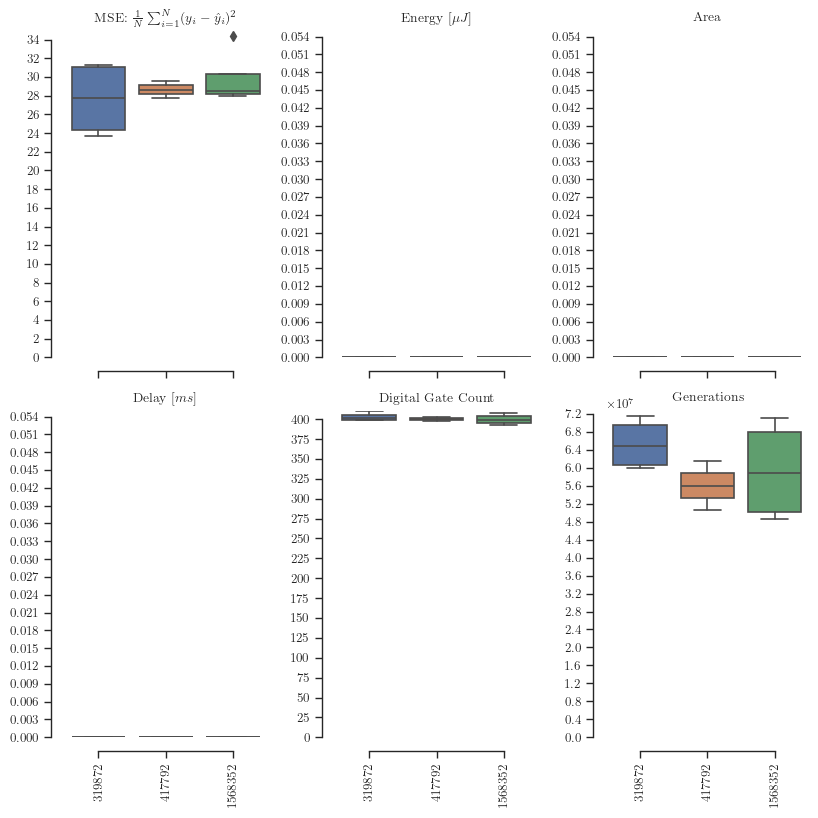

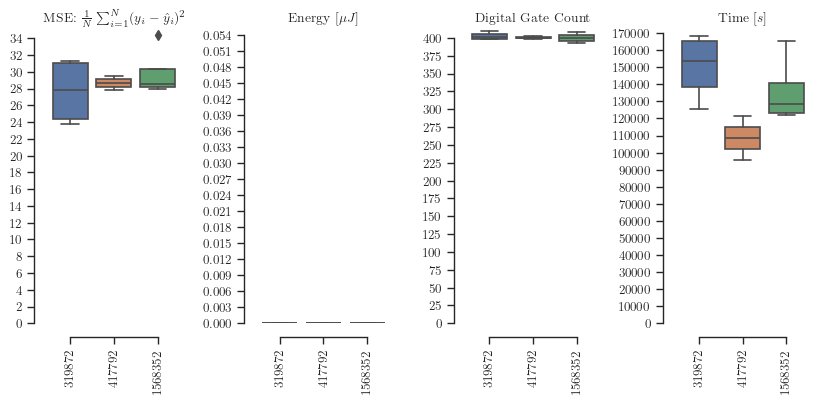

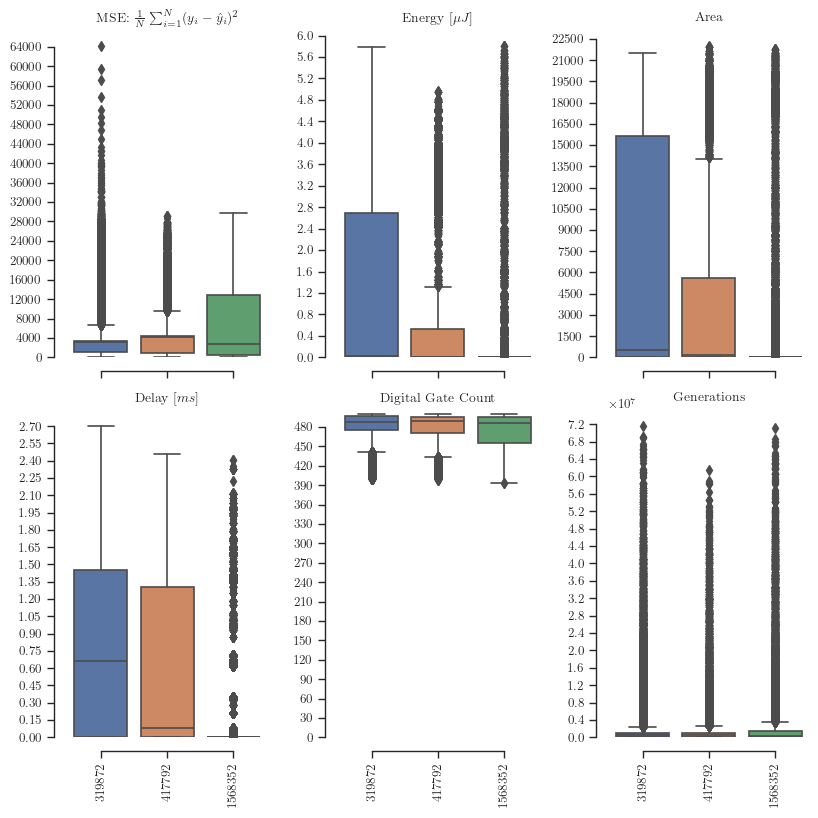

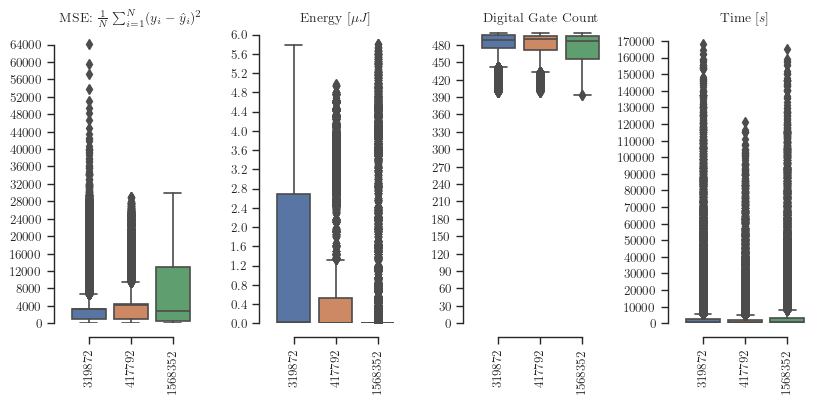

In [3]:
titles = {
    "Error": r"MSE: $\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$",
    "Energy": "Energy [$\mu J$]",
    "Area": "Area",
    "Delay": "Delay [$ms$]",
    "Gate Count": "Digital Gate Count",
    "Generation": "Generations",
    "Timestamp": "Time $[s]$"
}

def plot(solutions_df, col, ax, i, sharex_index=True):
    tick_count = 20
    g = sns.boxplot(data=solutions_df, x="MSE Threshold", y=col, ax=ax)
    g.yaxis.set_major_locator(plt.MaxNLocator(tick_count, min_n_ticks=10, integer=(col=="Gate Count")))
    g.set_ylim(0)
    g.set_title(titles[col])
    g.set_ylabel(None)
    g.set_xlabel(None)
    g.tick_params(axis="x", rotation=90)
    if i < sharex_index:
        g.axes.get_xaxis().set_ticklabels([])
        g.set_xlabel(None)
    return g    

def plot_columns(df, columns, r, c, sharex=True):
    fig, axes = plt.subplots(r, c, figsize=(8.27, 8.27 / 2 * r))
    for col, ax, i in zip(columns, axes.flat, range(r*c)):
        plot(df, col, ax, i, c if sharex else 0)    
    return fig

for x in ["best", "all"]:
    solutions_df = df if x == "best" else load_dfs(best_solution=False)
    fig_all = plot_columns(solutions_df, fitness_columns + ["Generation"], 2, 3)
    sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_all)
    fig_all.tight_layout()
    fig_all.savefig(figures / f"boxplot.{x}.png")
    fig_all.savefig(figures / f"boxplot.{x}.pdf")
    fig_all.savefig(figures / f"boxplot.{x}.svg")

    fig_brief = plot_columns(solutions_df, ["Error", "Energy", "Gate Count", "Timestamp"], 1, 4, sharex=False)
    sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_brief)
    fig_brief.tight_layout()
    fig_brief.savefig(figures / f"boxplot_{x}_brief.png")
    fig_brief.savefig(figures / f"boxplot_{x}_brief.pdf")
    fig_brief.savefig(figures / f"boxplot_{x}_brief.svg")

<Axes: xlabel='Gate Count', ylabel='Accuracy Loss'>

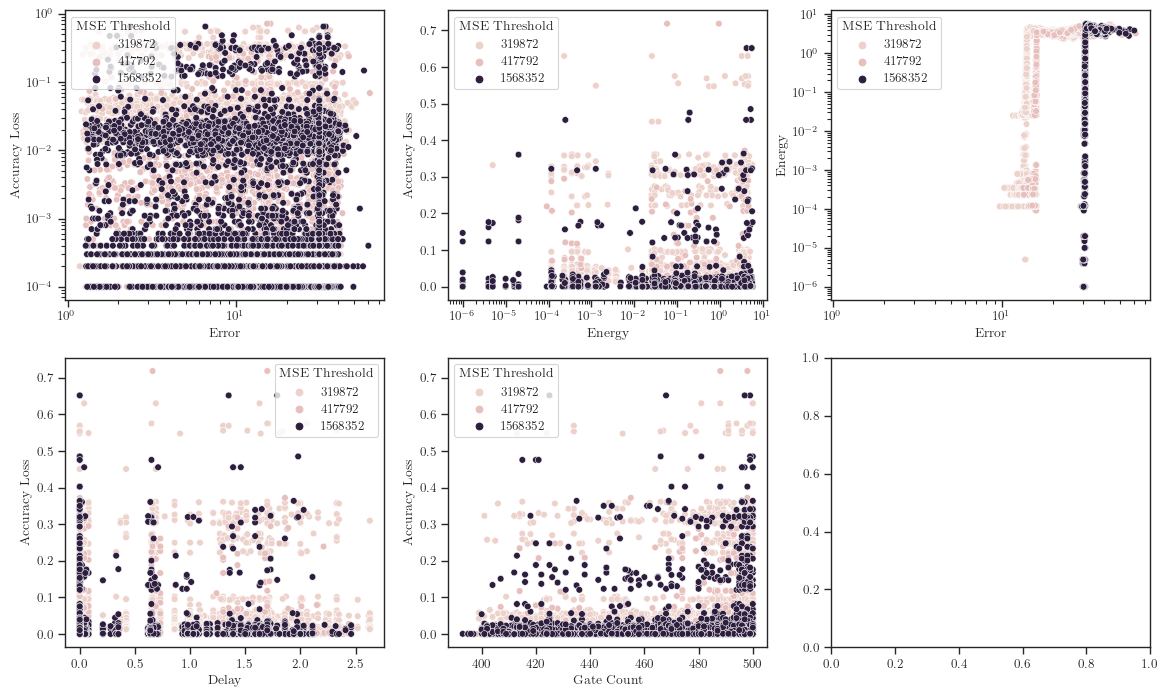

In [41]:
sns.set_palette("crest")
solutions_df = load_dfs(best_solution=False, model_acc=True)
# solutions_df = solutions_df.loc[solutions_df["Energy"] <= 10]

fig, ax = plt.subplots(2, 3, figsize=(14, 8.27))
ax = ax.flat
solutions_df["Accuracy Loss"] = 0.9916 - solutions_df["Top-1"]
solutions_df["Loss Delta"] = 0.032021708786 - solutions_df["Loss"]
g = sns.scatterplot(data=solutions_df, x="Error", y="Accuracy Loss", hue="MSE Threshold", ax=ax[0])
g.set(xscale="log", yscale="log")
g = sns.scatterplot(data=solutions_df, x="Energy", y="Accuracy Loss", hue="MSE Threshold", ax=ax[1])
g.set(xscale="log")
g = sns.scatterplot(data=solutions_df, x="Error", y="Energy", hue="MSE Threshold", ax=ax[2])
g.set(xscale="log", yscale="log")
sns.scatterplot(data=solutions_df, x="Delay", y="Accuracy Loss", hue="MSE Threshold", ax=ax[3])
sns.scatterplot(data=solutions_df, x="Gate Count", y="Accuracy Loss", hue="MSE Threshold", ax=ax[4])

In [25]:
# sns.pairplot(solutions_df.loc[:, ["Accuracy Loss", "Error", "Energy"]])
solutions_df.loc[(solutions_df["Accuracy Loss"] > 0.0) & (solutions_df["Error"] < 0.5) ]
solutions_df.sort_values(by=["Accuracy Loss"]).head(n=30)
# print(solutions_df.loc[(solutions_df["Run"] == 3) & (solutions_df["Generation"] == 56169919), "Chromosome"].iloc[0])

,Run,Generation,Timestamp,Error,Quantized Energy,Energy,Area,Quantized Delay,Delay,Gate Count,Chromosome,Top-1,Top-5,Loss,MSE Threshold,Experiment,Accuracy Loss,Loss Delta
9194,2,34413,70.655076,30.713662,120499595665168,0.000495,149.706696,126347562148695558,0.05,496,"{864,1536,10,50,2,10,2}([864]611,246,7)([865]3...",0.9920,1.0000,0.031937,1568352,fixed_mse_31_50_10.2.csv,-0.0004,0.000084
6194,11,3267,8.084649,35.069154,967600084757838273,3.974627,18713.806657,4118930526047475223,1.63,500,"{864,1536,10,50,2,10,2}([864]373,159,28)([865]...",0.9920,1.0000,0.031937,1568352,fixed_mse_31_50_10.11.csv,-0.0004,0.000084
8194,15,111032,282.267996,19.249538,0,0.000000,0.000000,0,0.00,493,"{864,1536,10,50,2,10,2}([864]763,577,22)([865]...",0.9920,1.0000,0.031937,1568352,fixed_mse_31_50_10.15.csv,-0.0004,0.000084
7194,12,1185518,2743.393619,6.133373,0,0.000000,0.000000,0,0.00,458,"{864,1536,10,50,2,10,2}([864]77,608,16)([865]5...",0.9920,1.0000,0.031937,1568352,fixed_mse_31_50_10.12.csv,-0.0004,0.000084
5444,7,159488,303.006576,15.823533,118184685343854999,0.485469,4331.169643,3285036615866084534,1.30,493,"{864,1536,10,50,2,10,2}([864]4,553,15)([865]65...",0.9919,1.0000,0.032178,417792,fixed_mse_16_50_10.7.csv,-0.0003,-0.000156
4736,6,76428,149.809453,17.728498,780981159180644440,3.208049,17865.312226,4548512237353040122,1.80,500,"{864,1536,10,50,2,10,2}([864]148,456,16)([865]...",0.9919,1.0000,0.032142,417792,fixed_mse_16_50_10.6.csv,-0.0003,-0.000120
6996,11,210579,499.370115,14.545399,0,0.000000,0.000000,0,0.00,484,"{864,1536,10,50,2,10,2}([864]4,11,19)([865]48,...",0.9919,1.0000,0.033891,1568352,fixed_mse_31_50_10.11.csv,-0.0003,-0.001870
7259,12,1243912,2877.931550,6.031474,0,0.000000,0.000000,0,0.00,461,"{864,1536,10,50,2,10,2}([864]77,608,16)([865]5...",0.9919,0.9999,0.034418,1568352,fixed_mse_31_50_10.12.csv,-0.0003,-0.002396
8742,15,2862524,7229.156878,3.837061,0,0.000000,0.000000,0,0.00,443,"{864,1536,10,50,2,10,2}([864]500,819,23)([865]...",0.9919,1.0000,0.032453,1568352,fixed_mse_31_50_10.15.csv,-0.0003,-0.000431
5123,7,3970,8.471402,34.239774,671154281712747918,2.756912,15462.965538,3588270765022953875,1.42,499,"{864,1536,10,50,2,10,2}([864]609,23,13)([865]4...",0.9919,1.0000,0.032128,417792,fixed_mse_16_50_10.7.csv,-0.0003,-0.000106
